In [150]:
"""
Customer Segmentation using RFM Analysis and K-Means Clustering
Author: Macnelson Ugochimereze Chibuike
Description:
This project segments customers based on their Recency, Frequency, and Monetary values
to identify groups like 'Loyal Customers', 'At Risk', 'Big Spenders', etc.
"""


"\nCustomer Segmentation using RFM Analysis and K-Means Clustering\nAuthor: Macnelson Ugochimereze Chibuike\nDescription:\nThis project segments customers based on their Recency, Frequency, and Monetary values\nto identify groups like 'Loyal Customers', 'At Risk', 'Big Spenders', etc.\n"

In [151]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")


In [152]:
# Dataset source:
# Online Retail Data (UCI Machine Learning Repository)
# https://archive.ics.uci.edu/ml/datasets/Online+Retail
df = pd.read_csv("online_retail.csv")

In [153]:
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [154]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [155]:
# Change the missing values in Description and drop the part of the CustomerID That is missing
df["Description"].fillna("Unknown", inplace=True)
df = df.dropna(subset=['CustomerID'])


In [156]:
# Check if there are any null values left
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [157]:
# Check for negative or zero values in Quantity and UnitPrice (they often mean returns or invalid data).


print(df[df["Quantity"] <= 0])

# Check for zero or negative prices
print(df[df["UnitPrice"] <= 0])


       InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

                InvoiceDate  UnitPrice  CustomerID         Country  
141     2010-12-01 09:41:00      27.50    

In [158]:
# Remove the negative or zero values in Quantity and UnitPrice
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]


In [159]:
#Verify Cleaning: After cleaning, re-check if the negative or zero values in Quantity and UnitPrice has been removed
print((df["Quantity"] <= 0).sum())   # should show 0
print((df["UnitPrice"] <= 0).sum())  # should show 0


0
0


In [160]:
# Next we perform RFM (Recency, Frequency, and Monetary) analysis.

# Recency is How recently a customer made a purchase, it measures Customer engagement or activeness
# Frequency is How often they buy, it measures Customer loyalty
# Monetary is how much money they spend, it measures customer value or worth.

In [161]:
# Computing RFM Step-by Step
# We'll then create a reference date using the last date in your dataset.
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
latest_date = df["InvoiceDate"].max()
print(latest_date)
# Group by each customer we'll calculate Recency, Frequency, and Monetary for each CustomerID.
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,   # Recency
    "InvoiceNo": "nunique", # Frequency
    "TotalPrice": "sum"  # Monetary
})

# You can rename the Columns for  Clarity
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)

# Check the new RFM table
rfm.head()

2011-12-09 12:50:00


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


In [162]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
rfm_features = rfm[["Recency", "Frequency", "Monetary"]]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=["Recency","Frequency", "Monetary"])
rfm_scaled_df.reset_index(drop=True, inplace=True)
print(rfm_scaled_df.head())

    Recency  Frequency  Monetary
0  2.334574  -0.425097  8.358668
1 -0.905340   0.354417  0.250966
2 -0.175360  -0.035340 -0.028596
3 -0.735345  -0.425097 -0.033012
4  2.174578  -0.425097 -0.191347


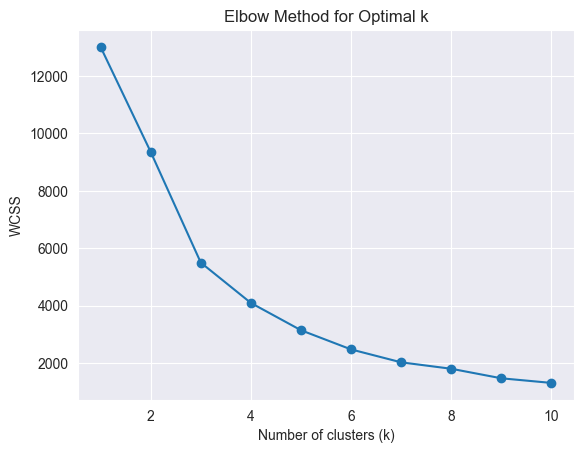

In [163]:
# Applying Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# We'll try different k values
wcss = []   # wcss measures how close the data points are to their cluster centers
# It stands for Within-Cluster Sum of Squares


# Test k from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS value

# Plot the elbow graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()


In [164]:
# training the kmeans model with the cluster number we've gotten
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled_df)

# Get cluster labels for each customer
rfm['Cluster'] = kmeans.labels_

# Assign human-readable labels to clusters
cluster_labels = {
    0: 'Loyal Customers',
    1: 'At Risk',
    2: 'New Customers',
    3: 'Big Spenders'
}
rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)


# View a few rows
print(rfm.head())

            Recency  Frequency  Monetary  Cluster    Cluster_Label
CustomerID                                                        
12346.0         325          1  77183.60        3     Big Spenders
12347.0           1          7   4310.00        0  Loyal Customers
12348.0          74          4   1797.24        0  Loyal Customers
12349.0          18          1   1757.55        0  Loyal Customers
12350.0         309          1    334.40        1          At Risk


In [165]:
rfm_cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print(rfm_cluster_summary)
# Sort clusters by Recency (lower means more recent activity)
rfm_cluster_summary = rfm_cluster_summary.sort_values('Recency')
print("\nSorted Cluster Summary (by Recency):")
print(rfm_cluster_summary)


         Recency  Frequency   Monetary
Cluster                               
0          42.70       3.68    1359.05
1         247.08       1.55     480.62
2           6.38      82.54  127338.31
3          14.50      22.33   12709.09

Sorted Cluster Summary (by Recency):
         Recency  Frequency   Monetary
Cluster                               
2           6.38      82.54  127338.31
3          14.50      22.33   12709.09
0          42.70       3.68    1359.05
1         247.08       1.55     480.62


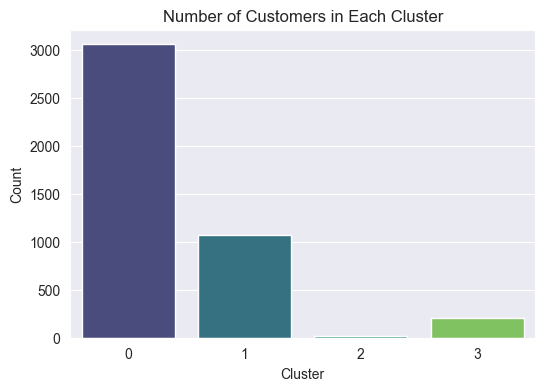

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='Cluster', data=rfm, palette='viridis')
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


<Figure size 1000x600 with 0 Axes>

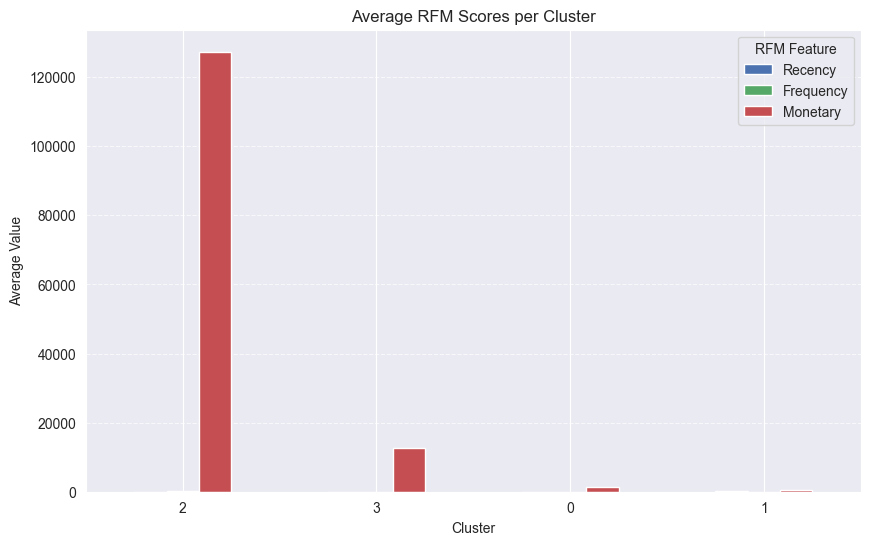

In [167]:
# Visual Summary of RFM Scores by Cluster
plt.figure(figsize=(10, 6))
rfm_cluster_summary[['Recency', 'Frequency', 'Monetary']].plot(
    kind='bar', figsize=(10, 6), color=['#4c72b0', '#55a868', '#c44e52']
)
plt.title("Average RFM Scores per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.legend(title="RFM Feature")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


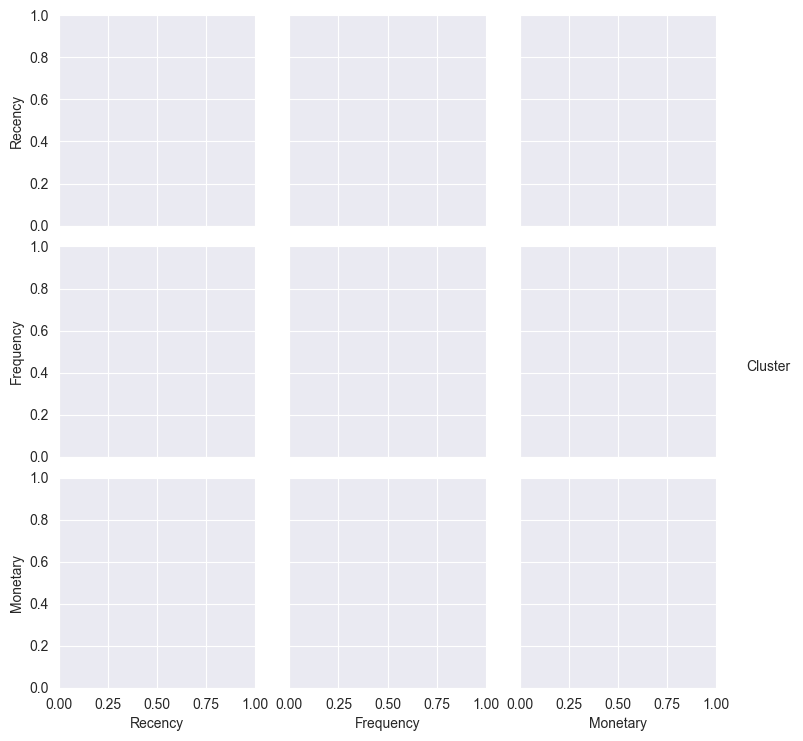

In [172]:
# Pairplot to show how clusters are separated
sns.pairplot(rfm_scaled_df.assign(Cluster=rfm['Cluster']).sample(500, random_state=42),
             hue='Cluster', palette='viridis', plot_kws={'alpha':0.6})


In [169]:
# Interpret and print summary insights for each cluster
print("\n--- Cluster Interpretation ---")
for cluster_id, row in rfm_cluster_summary.iterrows():
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']

    if recency < 30 and frequency > 20 and monetary > 10000:
        desc = "Loyal & High-Value Customers — buy often, spend a lot, and purchased recently."
    elif recency < 60 and frequency > 5:
        desc = "Regular Customers — purchase occasionally and are fairly active."
    elif recency > 150 and frequency < 3:
        desc = "At-Risk Customers — haven’t bought in a while and don’t purchase much."
    else:
        desc = "New or Low-Value Customers — recent or low-spending shoppers."

    print(f"Cluster {cluster_id}: {desc}")



--- Cluster Interpretation ---
Cluster 2: Loyal & High-Value Customers — buy often, spend a lot, and purchased recently.
Cluster 3: Loyal & High-Value Customers — buy often, spend a lot, and purchased recently.
Cluster 0: New or Low-Value Customers — recent or low-spending shoppers.
Cluster 1: At-Risk Customers — haven’t bought in a while and don’t purchase much.


In [170]:
# Save the clustered RFM table for future analysis
rfm.to_csv('rfm_clustered.csv', index=True)
print("Clustered RFM data saved as 'rfm_clustered.csv'")


Clustered RFM data saved as 'rfm_clustered.csv'
